# End-of-year "roll-over"

Single-year datasets retrieved from the PSM3 API with `utc=false` have a quirk
where the last few hours in the dataset are technically from the prior year.

I guess the reason is due to a process roughly as follows:
- The API grabs a calendar year of data in UTC
- The API converts to local time, thereby shifting a few January hours into the previous December
- The API takes those few hours in the previous year and puts them at the end
  of the dataset, thereby creating a complete calendar year again

In any case, it can create some minor inconsistencies in the last N hours of
the dataset, where N is the location's UTC offset.  This notebook shows
how it introduces discontinuities in temperature and humidity.  The
TODO notebook shows how it affects the solar position calculation.

In [3]:
import pvlib
import pandas as pd
import numpy as np

lat, lon = 40, -120

# note: get_psm3() specifies utc=false internally.
# nothing special about this place and time, other than the discontinuities
# being visually obvious.
df, meta = pvlib.iotools.get_psm3(lat, lon, 'DEMO_KEY', 'kevin.anderson@nrel.gov',
                                  names=2018, interval=5, map_variables=True, leap_day=True,
                                  attributes=['air_temperature', 'surface_pressure',
                                              'total_precipitable_water', 'relative_humidity'])

# drop nuisance cols, only keep the ones we want:
df = df[['temp_air', 'pressure', 'precipitable_water', 'relative_humidity']]


Taking a look at the last few hours of the year, notice the discontinuities:

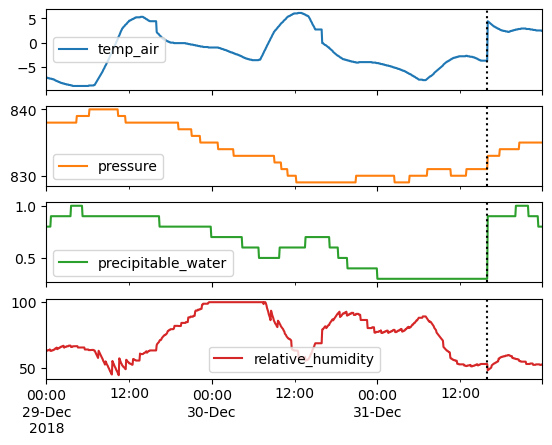

In [4]:
axes = df.loc['2018-12-29':].plot(subplots=True)

boundary = df.index[-1] + df.index[-1].utcoffset()
for ax in axes:
    ax.axvline(boundary, ls=':', c='k')

Now, let's move those last few hours back to the beginning where they originally came from.  See how nicely it joins up with the rest of the data?

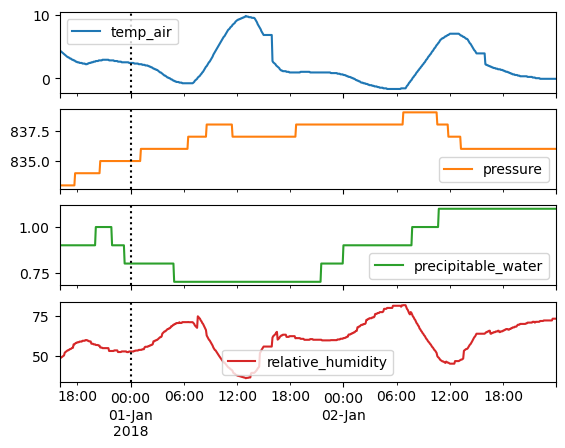

In [5]:
df_shift = df.copy()
df_shift.index = np.where(df_shift.index > boundary,
                          df_shift.index - pd.DateOffset(years=1),
                          df_shift.index)
df_shift = df_shift.sort_index()

axes = df_shift.loc[:'2018-01-02'].plot(subplots=True)
for ax in axes:
    ax.axvline(df.index[0], ls=':', c='k')

In [6]:
%load_ext watermark
%watermark --iversions -u -d -t

Last updated: 2022-09-21 18:07:13

numpy : 1.22.3
pandas: 1.5.0
pvlib : 0.9.3

